<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP (Part 2)


---
## Table of Contents

- Import of Libraries


- Data Cleaning


- Data Pre-processing

---

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import re
import string
import nltk

from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score, classification_report,confusion_matrix, ConfusionMatrixDisplay 
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, CategoricalNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.tree import plot_tree

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords



---
## Data Cleaning


-----
###### Import Data

In [2]:
real_estate = pd.read_csv('./datasets/real_estate.csv')
stocks = pd.read_csv('./datasets/stocks.csv')

In [3]:
real_estate.head(5)

,Unnamed: 0,subreddit,title,selftext
0,0,realestateinvesting,"CFP recommended ""10% rule"" for income??","In short, my wife and I are debating selling o..."
1,1,realestateinvesting,Southwest Florida,[removed]
2,2,realestateinvesting,New law for registering your new property,[removed]
3,3,realestateinvesting,What is Propertyneem? Real Estate services com...,[removed]
4,4,realestateinvesting,Best way to get a loan for short-term rental i...,[removed]


In [4]:
stocks.head(5)

,Unnamed: 0,subreddit,title,selftext
0,0,stocks,does return include dividend?,When looking at the historical return on a sto...
1,1,stocks,How my stop loss fucked me,[removed]
2,2,stocks,SpaceX revenue is expected to double in 2023.,[removed]
3,3,stocks,SpaceX revenue is expected to double in 2023. ...,[removed]
4,5,stocks,Should the fed hire more Latinos?,[removed]


##### Dropping of Unnamed Columns

In [5]:
real_estate.drop(columns = 'Unnamed: 0',axis = 1, inplace=True)
stocks.drop(columns = 'Unnamed: 0', axis = 1, inplace= True)

##### Dropping of Null Values

In [6]:
real_estate.dropna(inplace=True)
stocks.dropna(inplace=True)

##### Renamed `selftext` column to `descriptions` column

In [7]:
real_estate.rename(columns={"selftext": "description"},inplace=True)

In [8]:
stocks.rename(columns={"selftext": "description"},inplace=True)

##### Dropping of `[removed]` and `[deleted]` columns

In [9]:
real_estate = real_estate[real_estate['description'] != '[removed]']
stocks = stocks[stocks['description'] != '[removed]']

In [10]:
real_estate = real_estate[real_estate['description'] != '[deleted]']
stocks = stocks[stocks['description'] != '[deleted]']

##### Combining both description and title
 
As both title and description might contain useful words, it is better to combine them into a single columns

In [11]:
real_estate['title_desc'] = real_estate['title'] + " " + real_estate['description']
stocks['title_desc'] = stocks['title'] + " " + stocks['description']

##### Data Classification

Before performing classification, we will need change the variables into binary (1 or 0).

In [12]:
real_estate['subreddit'] = 1
stocks['subreddit'] = 0

##### Combining both dataframe into a single dataframe

This is for us to perform later, our train-test-split in our models

In [13]:
df = pd.merge(real_estate,stocks,how='outer')

In [14]:
#drop title and description
df = df.drop(columns = ['title','description'])
df.head()

,subreddit,title_desc
0,1,"CFP recommended ""10% rule"" for income?? In sho..."
1,1,Average Turn costs on 1900-1950s SFH Hey all. ...
2,1,Buying a triplex with a partner and personally...
3,1,Buying a decent-sized house in Bay Area/LA for...
4,1,"HOA rental restriction Hello, thinking about b..."


In [15]:
df.shape

(8867, 2)

In [16]:
#check for null values
df.isnull().sum().sum()

0

In [17]:
df[df['subreddit'] == 1].shape

(4135, 2)

------

A simple bar chart can be used to compare the number of posts about real estate and stocks. You could create a bar chart with two bars, one for real estate and one for stocks, and label each bar with the number of posts.

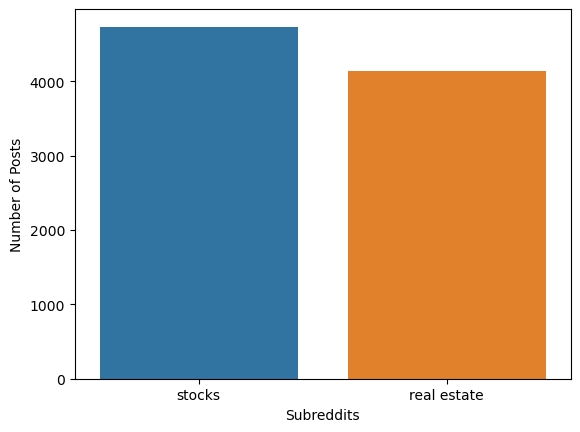

In [18]:
sns.countplot(x=df['subreddit']);

plt.xlabel('Subreddits')
plt.ylabel('Number of Posts')
plt.xticks([0, 1], ['stocks', 'real estate']);

**Comments**: Based on the above bar chart, although there are more posts on stocks than real estate, both have similar amount of posts which helps when training our model to prevent the model's accuracy. Also, as some real estate investing is related to stocks, there might be some post related to real estate in the stocks posts. 

----

## Dictionary



|Feature|Type|Dataset|Description|
|---|---|---|---|
|subreddit|Int||Subreddit Post which included `stocks` and `real estate investing`|

---

## Data Pre-processing

As our reddits consists of other unnecessary string character, further data pre-processing such as removal of specials characters, int and common words will be done to help improve our accuracy in our models.

In [19]:
# load the list of English stop words from the Natural Language Toolkit (NLTK) library in Python.
stop_words = set(nltk.corpus.stopwords.words('english'))

# import the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

The difference between lemmatizer and stemming is that lemmatizer is more suited for accuracy while stemming is for efficiency. As we want to train our model to be more accurate in finding the correct suited key categories, accuracy is more important hence we will use lemmatizer. 

In [20]:
def preprocess_text(text):
    
    #convert all text to lowercase
    text = text.lower()

    # remove punctuation from text
    text = "".join(filter(lambda char: char not in string.punctuation, text))

    # tokenize text into individual words
    words = word_tokenize(text)

    
    # lemmatize words using WordNetLemmatizer
    words = [lemmatizer.lemmatize(word.lower()) for word in words]
    

    # remove stop words from list of words
    stop_words = set(stopwords.words('english'))
    stop_words.add('stock')
    stop_words.add('real')
    stop_words.add('estate')
    words = [word for word in words if word.lower() not in stop_words]
    
    # remove words longer than 15 characters
    words = [word for word in words if len(word) <= 15]

    # remove numbers
    words = [re.sub(r"^\d+|\d$","",word) for word in words]
    
    #join all words 
    words = ' '.join(words)
    
    return words

In [21]:
df['preprocessed'] = df['title_desc'].apply(preprocess_text)

In [22]:
df.head(5)

,subreddit,title_desc,preprocessed
0,1,"CFP recommended ""10% rule"" for income?? In sho...",cfp recommended rule income short wife debati...
1,1,Average Turn costs on 1900-1950s SFH Hey all. ...,average turn cost s sfh hey use management com...
2,1,Buying a triplex with a partner and personally...,buying triplex partner personally living one u...
3,1,Buying a decent-sized house in Bay Area/LA for...,buying decentsized house bay areala large amou...
4,1,"HOA rental restriction Hello, thinking about b...",hoa rental restriction hello thinking buying t...


In [23]:
df = df[['subreddit','preprocessed']]
df.head(5)

,subreddit,preprocessed
0,1,cfp recommended rule income short wife debati...
1,1,average turn cost s sfh hey use management com...
2,1,buying triplex partner personally living one u...
3,1,buying decentsized house bay areala large amou...
4,1,hoa rental restriction hello thinking buying t...


---
## Exploratory Data Analysis

In [24]:
# instantiating countvectorizer
vectorizer = CountVectorizer(stop_words='english',ngram_range=(1,2))

<font size = 4> **Word cloud** </font>

Word cloud is used in my EDA as it offers quick understanding on the top 20 words with the frequency of each of them

<font size = 2> **_Stocks Reddit Post_** </font>

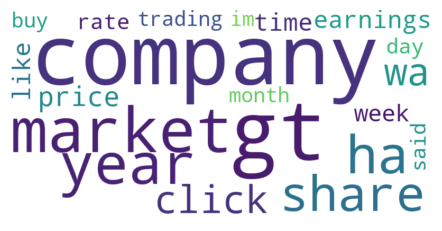

In [25]:
status_df = pd.DataFrame(vectorizer.fit_transform(df['preprocessed'].loc[df['subreddit']==0]).todense(), columns=vectorizer.get_feature_names_out())

# generate word cloud for top 20 words
wc = WordCloud(width=800, height=400, max_words=20, background_color='white').generate_from_frequencies(status_df.sum().sort_values(ascending=False).head(20))

plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

**Comments:** This wordcloud represent the reddit post for stocks. As we can see that the the word 'stocks' is the most common appeared word.

<font size = 2> **_Real Estate Investing Reddit Post_** </font>

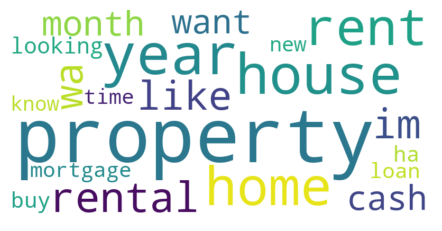

In [26]:
status_df = pd.DataFrame(vectorizer.fit_transform(df['preprocessed'].loc[df['subreddit']==1]).todense(), columns=vectorizer.get_feature_names_out())

# generate word cloud for top 20 words
wc = WordCloud(width=800, height=400, max_words=20, background_color='white').generate_from_frequencies(status_df.sum().sort_values(ascending=False).head(20))

plt.figure(figsize=(12,10))
plt.subplot(121)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off");

**Comments:** This wordcloud represent the reddit post for real estate investment. The most popular word seems to be 'property'.

<font size = 4>**Histogram for Post lengths**</font>

<font size = 2> **_Real Estate Investing Reddit Post_** </font>

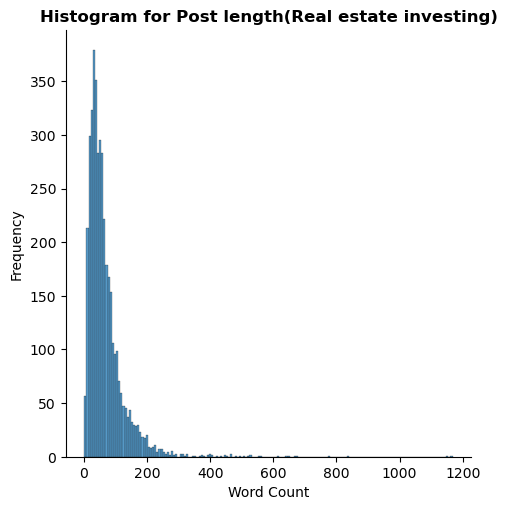

In [27]:
def count_words(words):
    return len(words.split())

sns.displot(df['preprocessed'].loc[df['subreddit']==1].map(count_words), kde=False);

plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.title('Histogram for Post length(Real estate investing)', fontsize=12, fontweight='bold');

**Comment:**

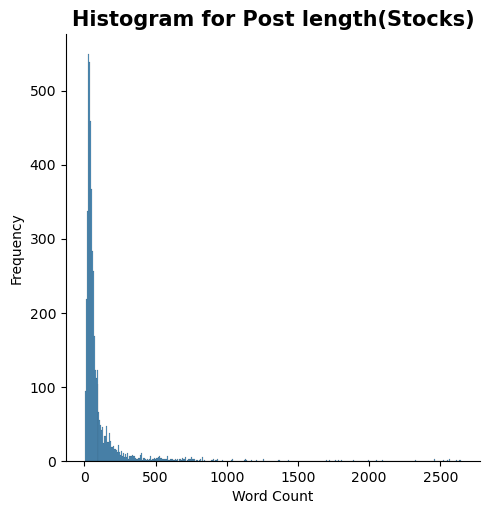

In [28]:
sns.displot(df['preprocessed'].loc[df['subreddit']==0].map(count_words), kde=False);

plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.title('Histogram for Post length(Stocks)', fontsize=15, fontweight='bold');

**Commment:**

<font size = 4>**Top 20 common words** </font>

In [29]:
#Def a function
def top_20_words(label,num):
    # instantiating countvectorizer
    vectorizer = CountVectorizer(stop_words='english',ngram_range=(num, num))

    status_df = pd.DataFrame(vectorizer.fit_transform(df['preprocessed'].loc[df['subreddit']==label]).todense(), columns=vectorizer.get_feature_names_out())
    
    print(len(status_df.columns))
    
    plt.figure(figsize=(8,8))
    status_df.sum().sort_values(ascending= False).head(20).plot(kind='barh')

22429


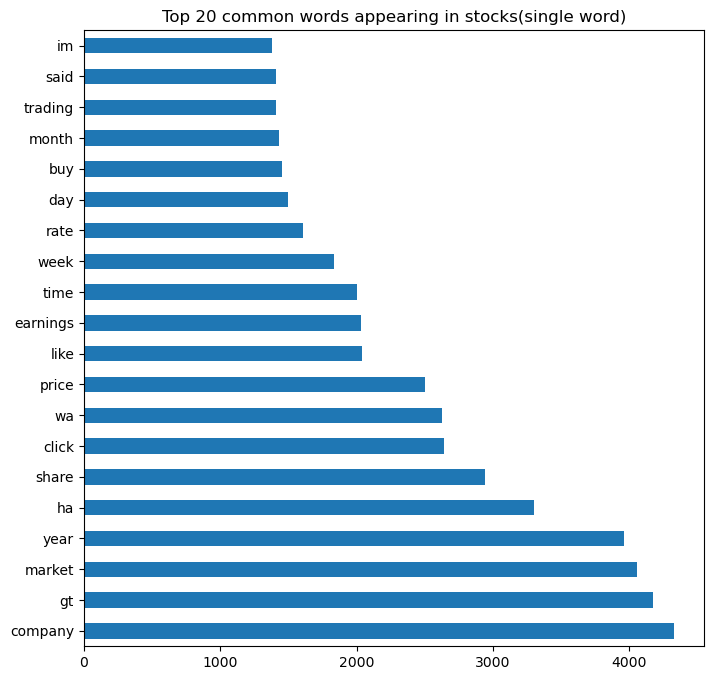

In [30]:
#Top 20 words
top_20_words(0,1)
plt.title('Top 20 common words appearing in stocks(single word)');

<font size = 2> **_real estate investing with single word_** </font>

12820


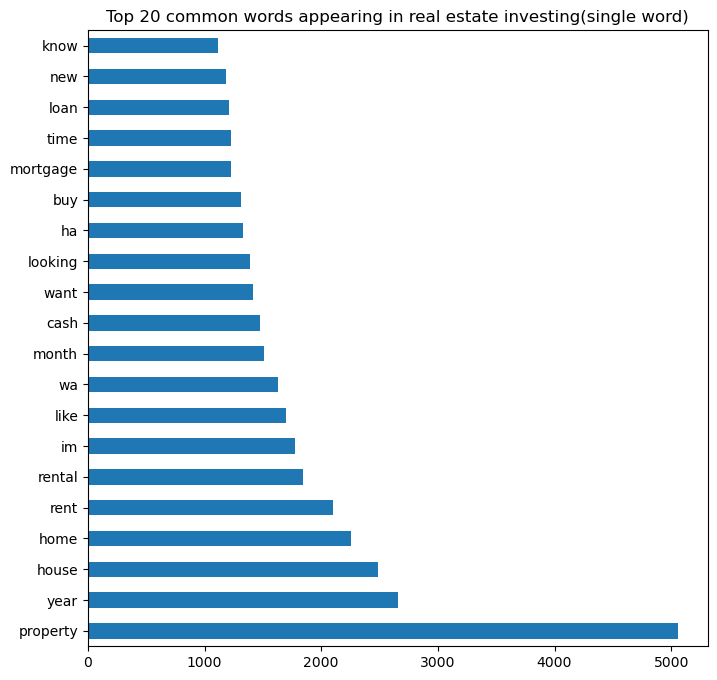

In [31]:
top_20_words(1,1)
plt.title('Top 20 common words appearing in real estate investing(single word)');

258245


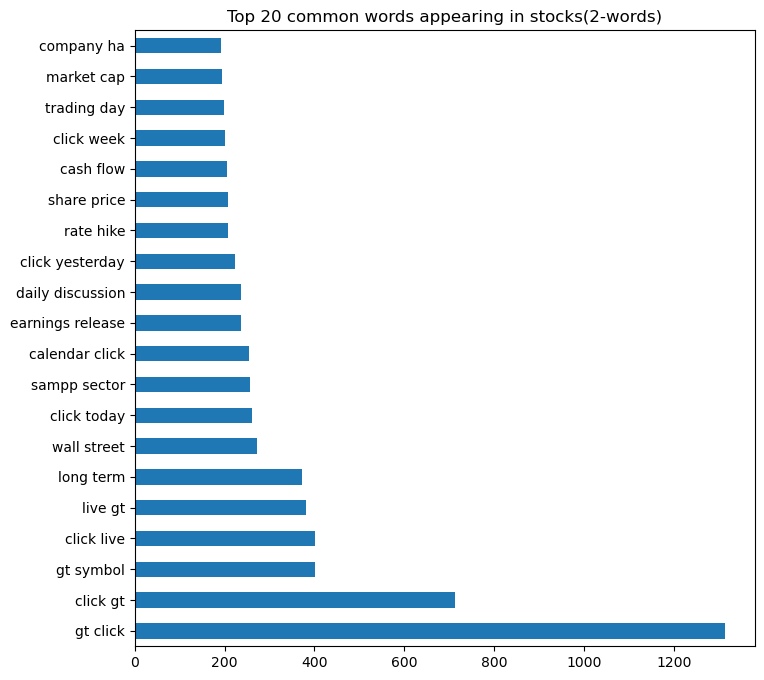

In [32]:
top_20_words(0,2)
plt.title('Top 20 common words appearing in stocks(2-words)');

152273


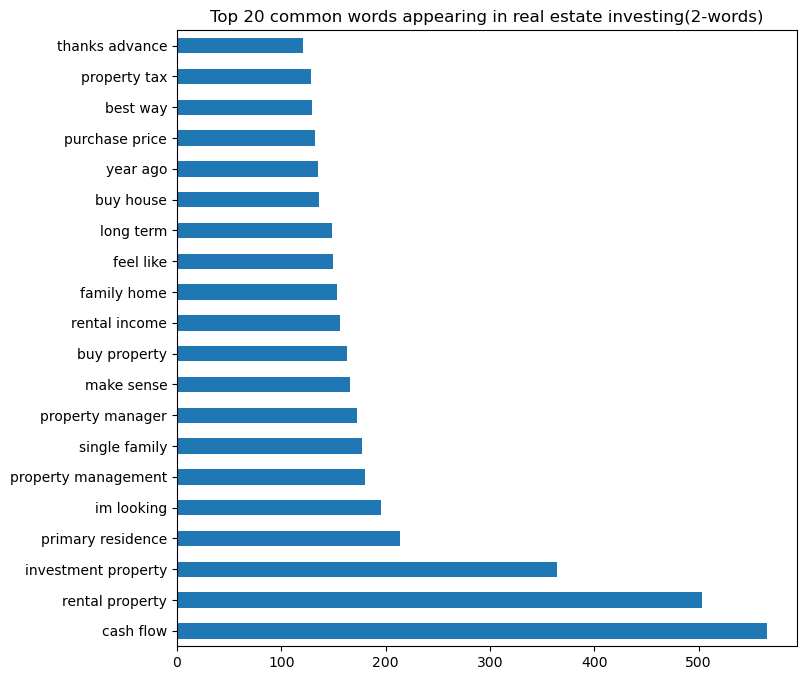

In [33]:
top_20_words(1,2)
plt.title('Top 20 common words appearing in real estate investing(2-words)');

---
## Train-Test-Split
---

In [34]:
X = df['preprocessed']
y = df['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size= 0.2,
                                                    random_state=42,
                                                    stratify=y
                                                   )

## Modelling Functions 

### General Function for all models

In [35]:
def model(training_data, test_data,model,param_grid,preprocessor):
    preprocessor = preprocessor
    
    # Transform the text data into numeric features
    X_train_binary = preprocessor.fit_transform(training_data)
    X_test_binary = preprocessor.transform(test_data)

    # Initialize the Bernoulli Naive Bayes classifier model
    classifier = model
    
    gs = GridSearchCV(classifier,cv = 5,param_grid = param_grid)

    # Fit the model on the training data
    gs.fit(X_train_binary, y_train)

    # Predict the classes on the testing data
    y_pred_train = gs.predict(X_train_binary)
    y_pred_test = gs.predict(X_test_binary) 

    
    # Calculate the accuracy score
    accuracy_train_score = accuracy_score(y_train, y_pred_train)
    accurracy_test_score = accuracy_score(y_test,y_pred_test)


    # Print the scores
    print('------------------------------------------------------------')
    print(f'Model: {str(model)}')
    print(f'Preprocessor: {str(preprocessor)}')
    print('------------------------------------------------------------')
    print(f"Train Score: {round(accuracy_train_score,4)}")
    print(f"Test Score: {round(accurracy_test_score,4)}")
    print('------------------------------------------------------------')
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------')
    

    return gs



### Function for Confusion Matrix

In [36]:
def conf_matrix(training_data, test_data, model, param_grid, preprocessor):
    preprocessor = preprocessor
    
    # Transform the text data into numeric features
    X_train_cm = preprocessor.fit_transform(training_data)
    X_test_cm = preprocessor.transform(test_data)

    # Initialize the Bernoulli Naive Bayes classifier model
    classifier = model
    
    gs = GridSearchCV(classifier,cv = 5,param_grid = param_grid)

    # Fit the model on the training data
    gs.fit(X_train_cm, y_train)

    # Predict the classes on the testing data
    y_pred_train = gs.predict(X_train_cm)
    y_pred_test = gs.predict(X_test_cm) 

    # Generate the confusion matrix for the test data
    cm = confusion_matrix(y_test, y_pred_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gs.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix of {str(preprocessor)}',fontsize=12,fontweight='bold')

    return gs


----
### Naive-Bayes 

There are 2 types of Naive-Bayes. One is the bernoulli which assumes that each feature (e.g. each word in a document) is binary, i.e., it is either present or absent in the document while the Multinomial is assuming that the features are counts, i.e., they represent the frequency of each feature (e.g. the number of times a word appears in a document). This is useful when the frequency of the features is important, such as in spam filtering, where the frequency of certain words or phrases can be a strong indicator of whether a message is spam or not. 

----

### _Naive-Bayes-Bernoulli_ 

**_Count Vectorizer_**

In [37]:
param_grid = {
    'alpha': [0.001], #[0.1, 0.01, 0.001],
    'binarize': [0.0], #[0.0, 0.1, 0.5, 0.9],
    'fit_prior': [True]
}

nb_count = model(X_train,X_test,BernoulliNB(),param_grid,CountVectorizer())

------------------------------------------------------------
Model: BernoulliNB()
Preprocessor: CountVectorizer()
------------------------------------------------------------
Train Score: 0.9415
Test Score: 0.8946
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.83      0.89       947
           1       0.83      0.97      0.90       827

    accuracy                           0.89      1774
   macro avg       0.90      0.90      0.89      1774
weighted avg       0.90      0.89      0.89      1774

------------------------------------------------------------


**_TF-IDF Vectorizer_**

In [38]:
param_grid = {
    'alpha': [0.1], #[0.1, 0.01, 0.001],
    'binarize': [0.1], #[0.0, 0.1, 0.5, 0.9],
    'fit_prior': [True]
}

nb_tfid = model(X_train,X_test,BernoulliNB(),param_grid,TfidfVectorizer())

------------------------------------------------------------
Model: BernoulliNB()
Preprocessor: TfidfVectorizer()
------------------------------------------------------------
Train Score: 0.9852
Test Score: 0.9566
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       947
           1       0.96      0.95      0.95       827

    accuracy                           0.96      1774
   macro avg       0.96      0.96      0.96      1774
weighted avg       0.96      0.96      0.96      1774

------------------------------------------------------------


**_TF-IDF Vectorizer (2-words)_**

In [39]:
param_grid = {
    'alpha': [0.001], #[0.1, 0.01, 0.001],
    'binarize': [0.1], #[0.0, 0.1, 0.5, 0.9],
    'fit_prior': [True]
}

uni_nb_tfid = model(X_train,X_test,BernoulliNB(),param_grid,TfidfVectorizer(ngram_range=(2,2)))

------------------------------------------------------------
Model: BernoulliNB()
Preprocessor: TfidfVectorizer(ngram_range=(2, 2))
------------------------------------------------------------
Train Score: 0.9927
Test Score: 0.9228
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       947
           1       0.91      0.93      0.92       827

    accuracy                           0.92      1774
   macro avg       0.92      0.92      0.92      1774
weighted avg       0.92      0.92      0.92      1774

------------------------------------------------------------


### _Naive Bayes Multinomial_

**_Count Vectorizer_**

In [40]:
param_grid = {
    'alpha': [0.001], #search over [0.1, 0.01, 0.001]
    'fit_prior': [True]
}
nb_multi_count = model(X_train,X_test,MultinomialNB(),param_grid,CountVectorizer())

------------------------------------------------------------
Model: MultinomialNB()
Preprocessor: CountVectorizer()
------------------------------------------------------------
Train Score: 0.9755
Test Score: 0.9464
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       947
           1       0.93      0.96      0.94       827

    accuracy                           0.95      1774
   macro avg       0.95      0.95      0.95      1774
weighted avg       0.95      0.95      0.95      1774

------------------------------------------------------------


**_TF-IDF Vectorizer_**

In [41]:
param_grid = {
    'alpha': [0.1], #search over [0.1, 0.01, 0.001]
    'fit_prior': [True]
}
nb_multi_tfid = model(X_train,X_test,MultinomialNB(),param_grid,TfidfVectorizer())

------------------------------------------------------------
Model: MultinomialNB()
Preprocessor: TfidfVectorizer()
------------------------------------------------------------
Train Score: 0.9836
Test Score: 0.9645
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       947
           1       0.96      0.96      0.96       827

    accuracy                           0.96      1774
   macro avg       0.96      0.96      0.96      1774
weighted avg       0.96      0.96      0.96      1774

------------------------------------------------------------


**_TF-IDF Vectorizer (2-words)_**

In [42]:
param_grid = {
    'alpha': [0.001], #[0.1, 0.01, 0.001],
    'fit_prior': [True]
}

uni_multi_tfid = model(X_train, X_test,MultinomialNB(),param_grid,TfidfVectorizer(ngram_range=(2,2)))

------------------------------------------------------------
Model: MultinomialNB()
Preprocessor: TfidfVectorizer(ngram_range=(2, 2))
------------------------------------------------------------
Train Score: 0.9997
Test Score: 0.9278
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       947
           1       0.91      0.94      0.92       827

    accuracy                           0.93      1774
   macro avg       0.93      0.93      0.93      1774
weighted avg       0.93      0.93      0.93      1774

------------------------------------------------------------


----
### Logistic Regression 

Logistic regression is a statistical model used in machine learning and data analysis to predict binary outcomes. In the context of subreddit posts, logistic regression can be used to predict whether a given post belongs to a specific subreddit or not. 

We will be combining with count vectorizer and term frequency-inverse document frequency (TF-IDF) to extract features from the text and improve the accuracy of the model.



----

**_Count Vectorizer_**

In [43]:
param_grid = {
    'penalty': ['l2'],
    'C': [1.0], #[[0.1, 1.0, 10.0]]
    'solver': ['newton-cg'], #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100] #[100, 500,1000]
}

logReg_count = model(X_train, X_test,LogisticRegression(),param_grid,CountVectorizer())

------------------------------------------------------------
Model: LogisticRegression()
Preprocessor: CountVectorizer()
------------------------------------------------------------
Train Score: 0.999
Test Score: 0.9622
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       947
           1       0.96      0.96      0.96       827

    accuracy                           0.96      1774
   macro avg       0.96      0.96      0.96      1774
weighted avg       0.96      0.96      0.96      1774

------------------------------------------------------------


**_TF-IDF Vectorizer_**

In [44]:
param_grid = {
    'penalty': ['l2'],
    'C': [10.0], #[0.1, 1.0, 10.0],
    'solver': ['newton-cg'],  #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100] #[100, 500,1000]
}

logReg_tfid = model(X_train, X_test,LogisticRegression(),param_grid,TfidfVectorizer())

------------------------------------------------------------
Model: LogisticRegression()
Preprocessor: TfidfVectorizer()
------------------------------------------------------------
Train Score: 0.9989
Test Score: 0.9662
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       947
           1       0.98      0.95      0.96       827

    accuracy                           0.97      1774
   macro avg       0.97      0.97      0.97      1774
weighted avg       0.97      0.97      0.97      1774

------------------------------------------------------------


**_TF-IDF Vectorizer (2-words)_**

In [45]:
param_grid = {
    'penalty': ['l2'],
    'C': [10.0], #[0.1, 1.0, 10.0],
    'solver': ['saga'], #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100] #[100, 500]
}

uni_logReg_tfid = model(X_train, X_test,LogisticRegression(),param_grid,TfidfVectorizer(ngram_range=(2,2)))

------------------------------------------------------------
Model: LogisticRegression()
Preprocessor: TfidfVectorizer(ngram_range=(2, 2))
------------------------------------------------------------
Train Score: 0.9997
Test Score: 0.9211
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       947
           1       0.95      0.88      0.91       827

    accuracy                           0.92      1774
   macro avg       0.92      0.92      0.92      1774
weighted avg       0.92      0.92      0.92      1774

------------------------------------------------------------


----
### Confusion Matrix

By using confusion matrix, it can evaluate how well the model is performing in predicting which subreddit a post belongs to. The matrix typically has four entries: true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN).

-----

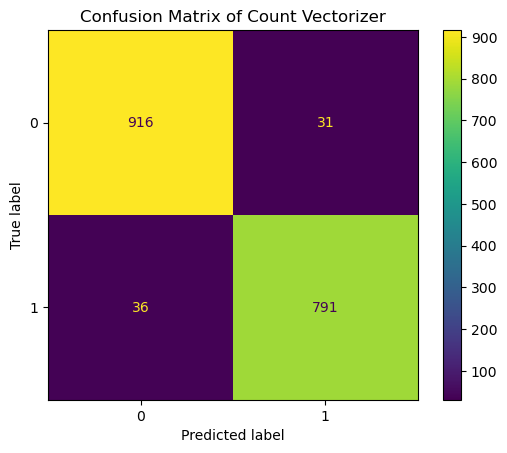

In [46]:
param_grid = {
    'penalty': ['l2'],
    'C': [1.0], #[[0.1, 1.0, 10.0]]
    'solver': ['newton-cg'], #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100] #[100, 500,1000]
}

logReg_CM = conf_matrix(X_train, X_test, LogisticRegression(),param_grid,CountVectorizer())
plt.title("Confusion Matrix of Count Vectorizer");

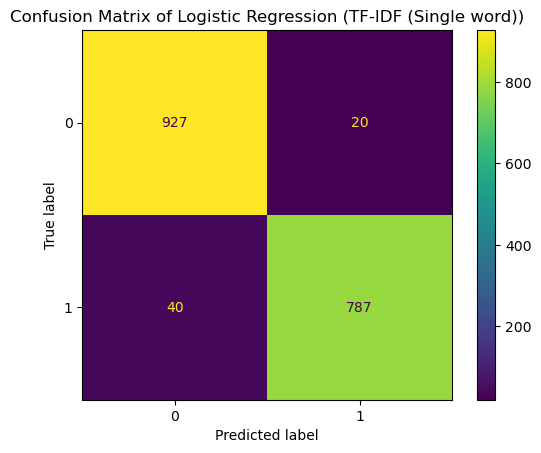

In [47]:
param_grid = {
    'penalty': ['l2'],
    'C': [10.0], #[0.1, 1.0, 10.0],
    'solver': ['newton-cg'],  #['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100] #[100, 500,1000]
}

logReg_tfid_CM = conf_matrix(X_train, X_test,LogisticRegression(),param_grid,TfidfVectorizer())
plt.title("Confusion Matrix of Logistic Regression (TF-IDF (Single word))");

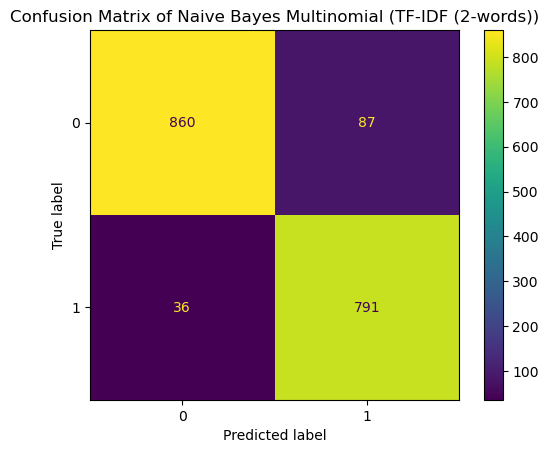

In [48]:
param_grid = {
    'alpha': [0.1], #search over [0.1, 0.01, 0.001]
    'fit_prior': [True]
}
nb_tfid_CM = conf_matrix(X_train,X_test,MultinomialNB(),param_grid,TfidfVectorizer(ngram_range=(2,2)))

plt.title("Confusion Matrix of Naive Bayes Multinomial (TF-IDF (2-words))");

-----
### Summary

|Model|Method|Train Score|Test Score|Precision(Stocks)|Precision(Real Estate)
|---|---|---|---|---|---|
|Logistic Regression|BOW|0.999|0.9622|0.96|0.96|
|Multinominal Naive Bayes|BOW|0.9755|0.9464|0.97|0.93|
|Bernoulli Naive Bayes|BOW|0.9415|0.8946|0.97|0.83|
|Random Forest|BOW|0.9999|0.9651|0.95|0.98|
|<b>Logistic Regression|<b>TF-IDF|<b>0.9989|<b>0.9662|<b>0.96|<b>0.98|
|Multinominal Naive Bayes|TF-IDF|0.9836|0.9645|0.97|0.96|
|Bernoulli Naive Bayes|TF-IDF|0.9852|0.9566|0.96|0.96|
|Random Forest|TF-IDF|0.9999|0.9594|0.94|0.98|
|Logistic Regression|n-gram(2,2)|0.9997|0.9211|0.90|0.95|
|Multinominal Naive Bayes|n-gram(2,2)|0.9997|0.9278|0.94|0.91|
|Bernoulli Naive Bayes|n-gram(2,2)|0.9927|0.9228|0.93|0.91|





In [54]:
def random_forest(training_data, test_data, model, vectorizer):
    
    
    X_train_vec = vectorizer.fit_transform(training_data)
    X_test_vec = vectorizer.transform(test_data)
    
    classifier = model
    
    rf_params = {
        'n_estimators': [150],
        'max_depth': [None, 1, 2, 3, 4, 5]
    }    
    
    gs = GridSearchCV(classifier,param_grid=rf_params,cv = 5)
    gs.fit(X_train_vec,y_train)

    
    # Predict the classes on the testing data
    y_pred_train = gs.predict(X_train_vec)
    y_pred_test = gs.predict(X_test_vec)
    
    accuracy_train_score = accuracy_score(y_train, y_pred_train)
    accurracy_test_score = accuracy_score(y_test,y_pred_test)
    
        # Print the scores
    print('------------------------------------------------------------')
    print(f'Model: {str(model)}')
    print(f'Preprocessor: {str(vectorizer)}')
    print('------------------------------------------------------------')
    print(f"Train Score: {round(accuracy_train_score,4)}")
    print(f"Test Score: {round(accurracy_test_score,4)}")
    print('------------------------------------------------------------')
    print(classification_report(y_test, y_pred_test))
    print('------------------------------------------------------------')
    
    
    return gs


In [55]:
rf = random_forest(X_train,X_test,RandomForestClassifier(),TfidfVectorizer())

------------------------------------------------------------
Model: RandomForestClassifier()
Preprocessor: TfidfVectorizer()
------------------------------------------------------------
Train Score: 0.9999
Test Score: 0.9594
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       947
           1       0.98      0.93      0.96       827

    accuracy                           0.96      1774
   macro avg       0.96      0.96      0.96      1774
weighted avg       0.96      0.96      0.96      1774

------------------------------------------------------------


In [56]:
rf_count = random_forest(X_train,X_test,RandomForestClassifier(),CountVectorizer())

------------------------------------------------------------
Model: RandomForestClassifier()
Preprocessor: CountVectorizer()
------------------------------------------------------------
Train Score: 0.9999
Test Score: 0.9651
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       947
           1       0.98      0.94      0.96       827

    accuracy                           0.97      1774
   macro avg       0.97      0.96      0.96      1774
weighted avg       0.97      0.97      0.96      1774

------------------------------------------------------------


In [52]:
def plot_impt(training_data,test_data, vectorizer):
    X_train_impt = vectorizer.fit_transform(training_data)
    X_test_impt= vectorizer.transform(test_data)
    
    # Get feature importance scores
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train_impt, y_train)
    
    # Train a Random Forest model on the training set
    importances = rf.feature_importances_
    
    # Create a dataframe to store feature names and their importance scores
    feature_importances_df = pd.DataFrame({'Feature_Name': vectorizer.get_feature_names_out(), 'Importance_Score': importances})

    # Sort the features by importance score in descending order
    feature_importances_df = feature_importances_df.sort_values(by='Importance_Score', ascending=False)[:15]
    
    # Create a bar chart using matplotlib
    plt.bar(feature_importances_df['Feature_Name'], feature_importances_df['Importance_Score'])
    plt.xticks(rotation=90)
    plt.title("Random Forest Feature Importance")
    plt.show()
    
    return feature_importances_df


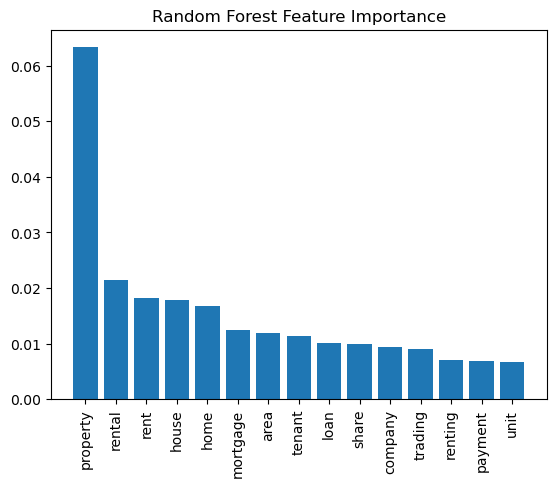

,Feature_Name,Importance_Score
16920,property,0.063303
18054,rental,0.021357
18047,rent,0.018193
10192,house,0.017755
10062,home,0.016766
13866,mortgage,0.012518
1276,area,0.011956
21708,tenant,0.011367
12457,loan,0.010166
19572,share,0.009991


In [53]:
plot_impt(X_train, X_test, TfidfVectorizer())